# London Public Perception Analysis

**Author: Giuseppe Vescina**

Utilizing datasets from the **Public Attitude Survey (PAS)** and detailed **Stop and Search records** this notebook aims to identify how various types of stop and search activities influence public perception.

### Data Sources

- **Public Attitude Survey (PAS)**: This survey collects opinions from approximately 600 residents per borough annually, aiming to gather feedback from over 19,000 residents for the fiscal year 2023-24. The results are collected quarterly and are accessible through [MOPAC's website](https://data.london.gov.uk/dataset/mopac-surveys).
- **Stop and Search Data**: Derived from [UK Police Data](https://data.police.uk/data/fetch/4d749f99-8717-4f2c-84f8-72ab35154bc4/), focusing on stop and search incidents involving minors from September 2022 to July 2023. This dataset was preprocessed in the `eda_youth_crime.ipynb`, located in the `eda` folder within the project directory.

### Geographic Focus

The analysis encompasses all 32 London boroughs, ensuring a comprehensive examination across a diverse demographic and geographic spectrum:
- Barking and Dagenham, Barnet, Bexley, Brent, Bromley, Camden, Croydon, Ealing, Enfield, Greenwich, Hackney, Hammersmith and Fulham, Haringey, Harrow, Havering, Hillingdon, Hounslow, Islington, Kensington and Chelsea, Kingston upon Thames, Lambeth, Lewisham, Merton, Newham, Redbridge, Richmond upon Thames, Southwark, Sutton, Tower Hamlets, Waltham Forest, Wandsworth, Westminster.

### Key Variables Analyzed

- **good_job**: Perception of police effectiveness in the local area.
- **trust**: Trust in the Metropolitan Police Service as a reliable organization.
- **fair_treatment**: Agreement that the police treat all individuals equitably, regardless of background.
- **dealing_issues**: Agreement that the police address the community's significant concerns.
- **crime_type**: Specific type of crime involved in each stop and search incident, as a critical variable in understanding the impact on public perception.
- **quarter**: Quarter in which the data was surveyed.
- **year_int**: Year of the survey, providing a temporal framework for analysis.

In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Loading datasets
pas = pd.read_csv("../data/pas_boroughs.csv")
filtered_stop_and_search = pd.read_csv("../data/filtered_stop_and_search.csv")

In [33]:
# Standardizing column names in PAS
pas.rename(columns={'borough': 'Borough'}, inplace=True)

# Converting 'Date' to datetime in the stop and search data, and extracting year and quarter
filtered_stop_and_search['Date'] = pd.to_datetime(filtered_stop_and_search['Date'])
filtered_stop_and_search['quarter'] = filtered_stop_and_search['Date'].dt.quarter
filtered_stop_and_search['year_int'] = filtered_stop_and_search['Date'].dt.year
crime_agg = filtered_stop_and_search.groupby(['Borough', 'quarter', 'year_int', 'Object of search']).size()

# Normalizing the counts to get the percentage distribution
crime_agg = crime_agg.unstack(fill_value=0)  
crime_agg = crime_agg.div(crime_agg.sum(axis=1), axis=0) 

# Resetting the index
crime_agg.reset_index(inplace=True)

# Calculating the average of trust, fair treatment, and dealing issues scores in PAS
pas['avg_perception'] = pas[['trust', 'fair_treatment', 'dealing_issues']].mean(axis=1)

# Merge the aggregated crime data with the PAS data 
merged_data = pd.merge(pas[['Borough', 'quarter', 'year_int', 'avg_perception']],
                       crime_agg, on=['Borough', 'quarter', 'year_int'], how='left')
merged_data.fillna(0, inplace=True)

print(merged_data.head())

                Borough  quarter  year_int  avg_perception  \
0  Barking and Dagenham      3.0      2023        0.643333   
1                Barnet      3.0      2023        0.640000   
2                Bexley      3.0      2023        0.676667   
3                 Brent      3.0      2023        0.673333   
4               Bromley      3.0      2023        0.600000   

   Anything to threaten or harm anyone  Articles for use in criminal damage  \
0                                  0.0                             0.018868   
1                                  0.0                             0.000000   
2                                  0.0                             0.000000   
3                                  0.0                             0.000000   
4                                  0.0                             0.053571   

   Controlled drugs  Evidence of offences under the Act  Firearms  Fireworks  \
0          0.320755                            0.188679  0.000000       

In [34]:
merged_data.fillna(0, inplace=True)

# Setting up independent variables (X) and the dependent variable (y)
X = merged_data.drop(['Borough', 'quarter', 'year_int', 'avg_perception'], axis=1)  # Independent variables (crime types)
y = merged_data['avg_perception']  # Dependent variable (average perception)

# Adding a constant to the model
X = sm.add_constant(X)

# Fitting the OLS model and printing the model summary
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         avg_perception   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.131
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           0.000100
Time:                        21:23:02   Log-Likelihood:                 434.02
No. Observations:                 352   AIC:                            -850.0
Df Residuals:                     343   BIC:                            -815.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

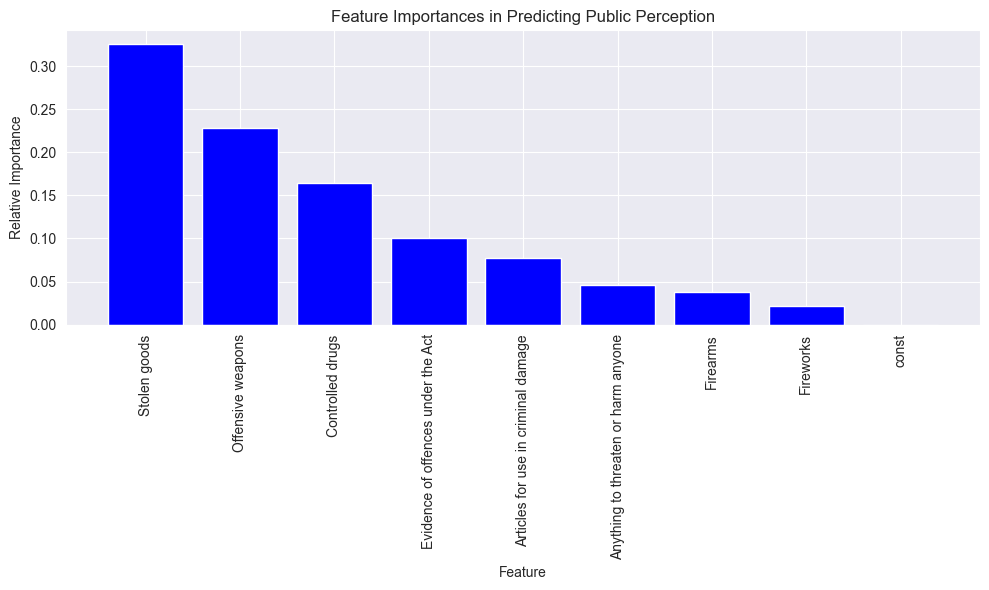

In [36]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_feature_names = [X.columns[i] for i in indices]
sorted_importances = importances[indices]

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances in Predicting Public Perception')

plt.bar(range(len(importances)), sorted_importances, color='b', align='center')
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)

plt.xlabel('Feature')
plt.ylabel('Relative Importance')

plt.tight_layout() 
plt.show()


In [79]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Initializing and fitting the Gradient Boosting model
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [81]:
# Predicting on the test set
y_pred = gbm.predict(X_test)

#Calculating performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 0.005968067716298663
R^2 Score: -0.13529174292470691


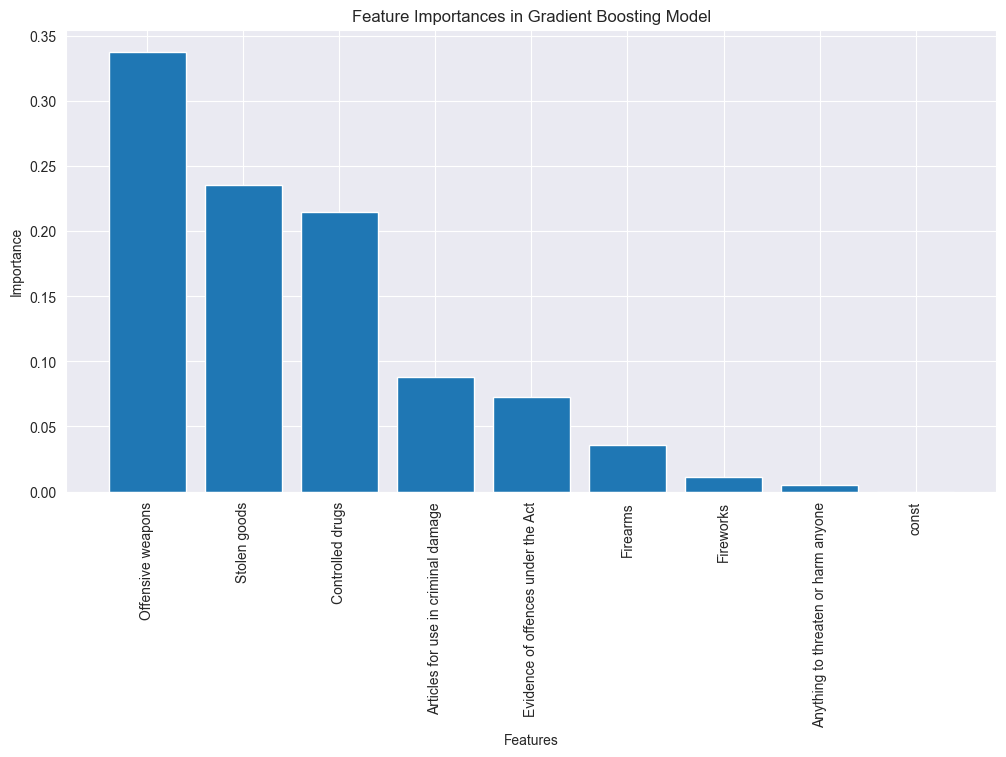

In [82]:
# Plot of the feature importances
feature_importances = gbm.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances in Gradient Boosting Model')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
